# Object detection with Keras and TS

- Documentation : https://www.tensorflow.org/hub/tutorials/object_detection?hl=fr

## Setup

In [20]:
%pip install -q tflite-model-maker
%pip install -q tflite-support
%pip install opencv-python-headless==4.5.2.52
!pip3 install pycocotools



try:
# pylint: disable=g-import-not-at-top
  from pycocotools.coco import COCO
  from pycocotools.cocoeval import COCOeval
# pylint: enable=g-import-not-at-top
except ImportError:
  print('Erreur')


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [21]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

## Chargement du jeu de données

In [22]:
train_folder = 'datasets/dataset.voc/train'
val_folder = 'datasets/dataset.voc/valid'
test_folder = 'datasets/dataset.voc/test'

# These images are used to train the object detection model to recognize plastic and can
train_data = object_detector.DataLoader.from_pascal_voc(
    train_folder,
    train_folder,
    ['plastique','canette']
)

# These images are used to evaluate the model. 
# These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid overfitting.
val_data = object_detector.DataLoader.from_pascal_voc(
    val_folder,
    val_folder,
    # label_map={1: "plastique", 2: "canette"}
    ['plastique','canette']
)

# These images are used to evaluate the final model performance.
test_data = object_detector.DataLoader.from_pascal_voc(
    test_folder,
    test_folder,
    ['plastique','canette']
)

## Mise en cache des données

In [23]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Selection du modèle

In [24]:
# Liste des modèles possibles : https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/model_spec
# spec = model_spec.get('mobilenet_v2')
# spec = model_spec.get('efficientdet_lite4')

verbose=1
tflite_max_detections=2

spec = model_spec.get('efficientdet_lite4')
spec.tflite_max_detections=tflite_max_detections
spec.verbose=verbose


## Entrainement du modèle

In [25]:
# Entraîner entièrement le modèle (fine-tuning) ?
train_whole_model=True
epochs=80
batch_size=5
model = object_detector.create(train_data, 
                               validation_data=val_data,
                               model_spec=spec, 
                               train_whole_model=train_whole_model,
                               epochs=epochs,
                               batch_size=batch_size
                               )


Epoch 1/50


2024-04-15 14:50:17.777688: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - ETA: 0s - det_loss: 1.7074 - cls_loss: 1.1199 - box_loss: 0.0117 - reg_l2_loss: 0.0063 - loss: 1.7137 - learning_rate: 0.0072 - gradient_norm: 0.8257

2024-04-15 14:51:30.468281: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 82s 3s/step - det_loss: 1.7033 - cls_loss: 1.1177 - box_loss: 0.0117 - reg_l2_loss: 0.0063 - loss: 1.7097 - learning_rate: 0.0071 - gradient_norm: 0.8229 - val_det_loss: 1.4439 - val_cls_loss: 1.0215 - val_box_loss: 0.0084 - val_reg_l2_loss: 0.0063 - val_loss: 1.4503
Epoch 2/50
21/21 [==============================] - ETA: 0s - det_loss: 1.3912 - cls_loss: 0.9343 - box_loss: 0.0091 - reg_l2_loss: 0.0064 - loss: 1.3975 - learning_rate: 0.0062 - gradient_norm: 1.1623

2024-04-15 14:52:21.566264: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 50s 2s/step - det_loss: 1.3855 - cls_loss: 0.9285 - box_loss: 0.0091 - reg_l2_loss: 0.0064 - loss: 1.3919 - learning_rate: 0.0062 - gradient_norm: 1.1591 - val_det_loss: 1.1980 - val_cls_loss: 0.8155 - val_box_loss: 0.0076 - val_reg_l2_loss: 0.0064 - val_loss: 1.2044
Epoch 3/50
21/21 [==============================] - ETA: 0s - det_loss: 1.1568 - cls_loss: 0.7412 - box_loss: 0.0083 - reg_l2_loss: 0.0064 - loss: 1.1632 - learning_rate: 0.0062 - gradient_norm: 1.4906

2024-04-15 14:53:22.785663: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 59s 3s/step - det_loss: 1.1592 - cls_loss: 0.7431 - box_loss: 0.0083 - reg_l2_loss: 0.0064 - loss: 1.1656 - learning_rate: 0.0062 - gradient_norm: 1.5082 - val_det_loss: 0.9758 - val_cls_loss: 0.6401 - val_box_loss: 0.0067 - val_reg_l2_loss: 0.0064 - val_loss: 0.9822
Epoch 4/50
21/21 [==============================] - ETA: 0s - det_loss: 0.9967 - cls_loss: 0.6417 - box_loss: 0.0071 - reg_l2_loss: 0.0064 - loss: 1.0031 - learning_rate: 0.0062 - gradient_norm: 1.5728

2024-04-15 14:54:16.995818: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 55s 3s/step - det_loss: 0.9901 - cls_loss: 0.6365 - box_loss: 0.0071 - reg_l2_loss: 0.0064 - loss: 0.9965 - learning_rate: 0.0062 - gradient_norm: 1.5599 - val_det_loss: 1.0183 - val_cls_loss: 0.6235 - val_box_loss: 0.0079 - val_reg_l2_loss: 0.0064 - val_loss: 1.0247
Epoch 5/50
21/21 [==============================] - ETA: 0s - det_loss: 0.9546 - cls_loss: 0.6116 - box_loss: 0.0069 - reg_l2_loss: 0.0064 - loss: 0.9610 - learning_rate: 0.0061 - gradient_norm: 1.6620

2024-04-15 14:55:08.135810: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 60s 3s/step - det_loss: 0.9533 - cls_loss: 0.6119 - box_loss: 0.0068 - reg_l2_loss: 0.0064 - loss: 0.9597 - learning_rate: 0.0061 - gradient_norm: 1.6531 - val_det_loss: 0.9176 - val_cls_loss: 0.5401 - val_box_loss: 0.0075 - val_reg_l2_loss: 0.0064 - val_loss: 0.9240
Epoch 6/50
21/21 [==============================] - ETA: 0s - det_loss: 0.9020 - cls_loss: 0.5662 - box_loss: 0.0067 - reg_l2_loss: 0.0064 - loss: 0.9084 - learning_rate: 0.0061 - gradient_norm: 1.4997

2024-04-15 14:56:05.850965: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 48s 2s/step - det_loss: 0.9109 - cls_loss: 0.5703 - box_loss: 0.0068 - reg_l2_loss: 0.0064 - loss: 0.9173 - learning_rate: 0.0061 - gradient_norm: 1.4960 - val_det_loss: 0.8959 - val_cls_loss: 0.5136 - val_box_loss: 0.0076 - val_reg_l2_loss: 0.0064 - val_loss: 0.9024
Epoch 7/50
21/21 [==============================] - ETA: 0s - det_loss: 0.8598 - cls_loss: 0.5539 - box_loss: 0.0061 - reg_l2_loss: 0.0064 - loss: 0.8663 - learning_rate: 0.0060 - gradient_norm: 1.7720

2024-04-15 14:56:54.990984: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 50s 2s/step - det_loss: 0.8533 - cls_loss: 0.5514 - box_loss: 0.0060 - reg_l2_loss: 0.0064 - loss: 0.8598 - learning_rate: 0.0060 - gradient_norm: 1.7593 - val_det_loss: 0.8711 - val_cls_loss: 0.5262 - val_box_loss: 0.0069 - val_reg_l2_loss: 0.0064 - val_loss: 0.8775
Epoch 8/50
21/21 [==============================] - ETA: 0s - det_loss: 0.8176 - cls_loss: 0.5167 - box_loss: 0.0060 - reg_l2_loss: 0.0064 - loss: 0.8240 - learning_rate: 0.0059 - gradient_norm: 1.7003

2024-04-15 14:57:49.568173: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 55s 3s/step - det_loss: 0.8261 - cls_loss: 0.5227 - box_loss: 0.0061 - reg_l2_loss: 0.0064 - loss: 0.8325 - learning_rate: 0.0059 - gradient_norm: 1.6971 - val_det_loss: 0.9610 - val_cls_loss: 0.5999 - val_box_loss: 0.0072 - val_reg_l2_loss: 0.0064 - val_loss: 0.9674
Epoch 9/50
21/21 [==============================] - ETA: 0s - det_loss: 0.8622 - cls_loss: 0.5406 - box_loss: 0.0064 - reg_l2_loss: 0.0064 - loss: 0.8686 - learning_rate: 0.0058 - gradient_norm: 2.0745

2024-04-15 14:58:40.002144: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 55s 3s/step - det_loss: 0.8613 - cls_loss: 0.5398 - box_loss: 0.0064 - reg_l2_loss: 0.0064 - loss: 0.8678 - learning_rate: 0.0058 - gradient_norm: 2.0633 - val_det_loss: 0.8370 - val_cls_loss: 0.5030 - val_box_loss: 0.0067 - val_reg_l2_loss: 0.0064 - val_loss: 0.8434
Epoch 10/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7692 - cls_loss: 0.4865 - box_loss: 0.0057 - reg_l2_loss: 0.0064 - loss: 0.7757 - learning_rate: 0.0057 - gradient_norm: 1.5975

2024-04-15 14:59:36.556213: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 60s 3s/step - det_loss: 0.7642 - cls_loss: 0.4831 - box_loss: 0.0056 - reg_l2_loss: 0.0064 - loss: 0.7706 - learning_rate: 0.0057 - gradient_norm: 1.5799 - val_det_loss: 0.8705 - val_cls_loss: 0.5175 - val_box_loss: 0.0071 - val_reg_l2_loss: 0.0064 - val_loss: 0.8769
Epoch 11/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7833 - cls_loss: 0.5042 - box_loss: 0.0056 - reg_l2_loss: 0.0064 - loss: 0.7898 - learning_rate: 0.0056 - gradient_norm: 1.7205

2024-04-15 15:00:36.300464: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 52s 2s/step - det_loss: 0.7880 - cls_loss: 0.5078 - box_loss: 0.0056 - reg_l2_loss: 0.0064 - loss: 0.7944 - learning_rate: 0.0056 - gradient_norm: 1.7130 - val_det_loss: 0.8664 - val_cls_loss: 0.5073 - val_box_loss: 0.0072 - val_reg_l2_loss: 0.0064 - val_loss: 0.8728
Epoch 12/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7429 - cls_loss: 0.4630 - box_loss: 0.0056 - reg_l2_loss: 0.0064 - loss: 0.7494 - learning_rate: 0.0054 - gradient_norm: 1.6419

2024-04-15 15:01:27.342758: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 51s 2s/step - det_loss: 0.7430 - cls_loss: 0.4632 - box_loss: 0.0056 - reg_l2_loss: 0.0064 - loss: 0.7495 - learning_rate: 0.0054 - gradient_norm: 1.6537 - val_det_loss: 0.8737 - val_cls_loss: 0.5005 - val_box_loss: 0.0075 - val_reg_l2_loss: 0.0064 - val_loss: 0.8801
Epoch 13/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7517 - cls_loss: 0.4744 - box_loss: 0.0055 - reg_l2_loss: 0.0065 - loss: 0.7581 - learning_rate: 0.0053 - gradient_norm: 1.6635

2024-04-15 15:02:20.277761: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 53s 3s/step - det_loss: 0.7516 - cls_loss: 0.4734 - box_loss: 0.0056 - reg_l2_loss: 0.0065 - loss: 0.7580 - learning_rate: 0.0053 - gradient_norm: 1.6707 - val_det_loss: 0.8680 - val_cls_loss: 0.5188 - val_box_loss: 0.0070 - val_reg_l2_loss: 0.0065 - val_loss: 0.8744
Epoch 14/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6980 - cls_loss: 0.4542 - box_loss: 0.0049 - reg_l2_loss: 0.0065 - loss: 0.7044 - learning_rate: 0.0052 - gradient_norm: 1.6985

2024-04-15 15:03:07.734327: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 47s 2s/step - det_loss: 0.6979 - cls_loss: 0.4544 - box_loss: 0.0049 - reg_l2_loss: 0.0065 - loss: 0.7044 - learning_rate: 0.0052 - gradient_norm: 1.7024 - val_det_loss: 0.8913 - val_cls_loss: 0.5185 - val_box_loss: 0.0075 - val_reg_l2_loss: 0.0065 - val_loss: 0.8978
Epoch 15/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6768 - cls_loss: 0.4299 - box_loss: 0.0049 - reg_l2_loss: 0.0065 - loss: 0.6832 - learning_rate: 0.0050 - gradient_norm: 1.6683

2024-04-15 15:03:56.434400: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 56s 3s/step - det_loss: 0.6775 - cls_loss: 0.4310 - box_loss: 0.0049 - reg_l2_loss: 0.0065 - loss: 0.6839 - learning_rate: 0.0050 - gradient_norm: 1.6591 - val_det_loss: 0.8095 - val_cls_loss: 0.4946 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0065 - val_loss: 0.8160
Epoch 16/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7313 - cls_loss: 0.4654 - box_loss: 0.0053 - reg_l2_loss: 0.0065 - loss: 0.7377 - learning_rate: 0.0048 - gradient_norm: 1.8797

2024-04-15 15:04:52.216885: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 49s 2s/step - det_loss: 0.7293 - cls_loss: 0.4659 - box_loss: 0.0053 - reg_l2_loss: 0.0065 - loss: 0.7358 - learning_rate: 0.0048 - gradient_norm: 1.9092 - val_det_loss: 0.7877 - val_cls_loss: 0.4779 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0065 - val_loss: 0.7942
Epoch 17/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7100 - cls_loss: 0.4448 - box_loss: 0.0053 - reg_l2_loss: 0.0065 - loss: 0.7164 - learning_rate: 0.0047 - gradient_norm: 1.7368

2024-04-15 15:05:46.392009: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 55s 3s/step - det_loss: 0.7183 - cls_loss: 0.4489 - box_loss: 0.0054 - reg_l2_loss: 0.0065 - loss: 0.7248 - learning_rate: 0.0047 - gradient_norm: 1.7378 - val_det_loss: 0.8171 - val_cls_loss: 0.4897 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0065 - val_loss: 0.8235
Epoch 18/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6687 - cls_loss: 0.4201 - box_loss: 0.0050 - reg_l2_loss: 0.0065 - loss: 0.6752 - learning_rate: 0.0045 - gradient_norm: 1.6325

2024-04-15 15:06:42.958258: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 56s 3s/step - det_loss: 0.6748 - cls_loss: 0.4228 - box_loss: 0.0050 - reg_l2_loss: 0.0065 - loss: 0.6813 - learning_rate: 0.0045 - gradient_norm: 1.6283 - val_det_loss: 0.8172 - val_cls_loss: 0.4768 - val_box_loss: 0.0068 - val_reg_l2_loss: 0.0065 - val_loss: 0.8237
Epoch 19/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7314 - cls_loss: 0.4614 - box_loss: 0.0054 - reg_l2_loss: 0.0065 - loss: 0.7379 - learning_rate: 0.0043 - gradient_norm: 2.0841

2024-04-15 15:07:31.805103: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 49s 2s/step - det_loss: 0.7257 - cls_loss: 0.4564 - box_loss: 0.0054 - reg_l2_loss: 0.0065 - loss: 0.7322 - learning_rate: 0.0043 - gradient_norm: 2.0654 - val_det_loss: 0.8399 - val_cls_loss: 0.5062 - val_box_loss: 0.0067 - val_reg_l2_loss: 0.0065 - val_loss: 0.8464
Epoch 20/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6749 - cls_loss: 0.4254 - box_loss: 0.0050 - reg_l2_loss: 0.0065 - loss: 0.6814 - learning_rate: 0.0041 - gradient_norm: 1.7494

2024-04-15 15:08:20.688366: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 56s 3s/step - det_loss: 0.6714 - cls_loss: 0.4221 - box_loss: 0.0050 - reg_l2_loss: 0.0065 - loss: 0.6779 - learning_rate: 0.0041 - gradient_norm: 1.7313 - val_det_loss: 0.8211 - val_cls_loss: 0.4883 - val_box_loss: 0.0067 - val_reg_l2_loss: 0.0065 - val_loss: 0.8275
Epoch 21/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7291 - cls_loss: 0.4712 - box_loss: 0.0052 - reg_l2_loss: 0.0065 - loss: 0.7356 - learning_rate: 0.0039 - gradient_norm: 2.0002

2024-04-15 15:09:15.917050: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 50s 2s/step - det_loss: 0.7283 - cls_loss: 0.4709 - box_loss: 0.0051 - reg_l2_loss: 0.0065 - loss: 0.7348 - learning_rate: 0.0039 - gradient_norm: 1.9977 - val_det_loss: 0.9022 - val_cls_loss: 0.5552 - val_box_loss: 0.0069 - val_reg_l2_loss: 0.0065 - val_loss: 0.9087
Epoch 22/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6973 - cls_loss: 0.4426 - box_loss: 0.0051 - reg_l2_loss: 0.0065 - loss: 0.7038 - learning_rate: 0.0037 - gradient_norm: 1.8853

2024-04-15 15:10:04.480272: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 47s 2s/step - det_loss: 0.6884 - cls_loss: 0.4379 - box_loss: 0.0050 - reg_l2_loss: 0.0065 - loss: 0.6949 - learning_rate: 0.0037 - gradient_norm: 1.8806 - val_det_loss: 0.7908 - val_cls_loss: 0.4819 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0065 - val_loss: 0.7973
Epoch 23/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6641 - cls_loss: 0.4212 - box_loss: 0.0049 - reg_l2_loss: 0.0065 - loss: 0.6705 - learning_rate: 0.0035 - gradient_norm: 1.7160

2024-04-15 15:10:51.207727: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 47s 2s/step - det_loss: 0.6583 - cls_loss: 0.4172 - box_loss: 0.0048 - reg_l2_loss: 0.0065 - loss: 0.6648 - learning_rate: 0.0035 - gradient_norm: 1.6994 - val_det_loss: 0.8131 - val_cls_loss: 0.4981 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0065 - val_loss: 0.8196
Epoch 24/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6525 - cls_loss: 0.4136 - box_loss: 0.0048 - reg_l2_loss: 0.0065 - loss: 0.6590 - learning_rate: 0.0033 - gradient_norm: 1.7323

2024-04-15 15:11:37.979836: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 46s 2s/step - det_loss: 0.6562 - cls_loss: 0.4181 - box_loss: 0.0048 - reg_l2_loss: 0.0065 - loss: 0.6627 - learning_rate: 0.0033 - gradient_norm: 1.7403 - val_det_loss: 0.7554 - val_cls_loss: 0.4658 - val_box_loss: 0.0058 - val_reg_l2_loss: 0.0065 - val_loss: 0.7619
Epoch 25/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6733 - cls_loss: 0.4237 - box_loss: 0.0050 - reg_l2_loss: 0.0065 - loss: 0.6798 - learning_rate: 0.0031 - gradient_norm: 1.8475

2024-04-15 15:12:25.363576: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 55s 3s/step - det_loss: 0.6785 - cls_loss: 0.4243 - box_loss: 0.0051 - reg_l2_loss: 0.0065 - loss: 0.6850 - learning_rate: 0.0031 - gradient_norm: 1.8674 - val_det_loss: 0.7623 - val_cls_loss: 0.4519 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0065 - val_loss: 0.7688
Epoch 26/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6659 - cls_loss: 0.4212 - box_loss: 0.0049 - reg_l2_loss: 0.0065 - loss: 0.6724 - learning_rate: 0.0029 - gradient_norm: 1.9194

2024-04-15 15:13:21.822262: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 50s 2s/step - det_loss: 0.6644 - cls_loss: 0.4226 - box_loss: 0.0048 - reg_l2_loss: 0.0065 - loss: 0.6709 - learning_rate: 0.0029 - gradient_norm: 1.9161 - val_det_loss: 0.7788 - val_cls_loss: 0.4753 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0065 - val_loss: 0.7853
Epoch 27/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6293 - cls_loss: 0.3994 - box_loss: 0.0046 - reg_l2_loss: 0.0065 - loss: 0.6358 - learning_rate: 0.0027 - gradient_norm: 1.7518

2024-04-15 15:14:14.520143: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 54s 3s/step - det_loss: 0.6280 - cls_loss: 0.3975 - box_loss: 0.0046 - reg_l2_loss: 0.0065 - loss: 0.6345 - learning_rate: 0.0027 - gradient_norm: 1.7546 - val_det_loss: 0.7797 - val_cls_loss: 0.4599 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0065 - val_loss: 0.7862
Epoch 28/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6567 - cls_loss: 0.4160 - box_loss: 0.0048 - reg_l2_loss: 0.0065 - loss: 0.6632 - learning_rate: 0.0025 - gradient_norm: 1.9316

2024-04-15 15:15:11.404534: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 54s 3s/step - det_loss: 0.6506 - cls_loss: 0.4126 - box_loss: 0.0048 - reg_l2_loss: 0.0065 - loss: 0.6571 - learning_rate: 0.0025 - gradient_norm: 1.9535 - val_det_loss: 0.7860 - val_cls_loss: 0.4594 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0065 - val_loss: 0.7925
Epoch 29/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6637 - cls_loss: 0.4148 - box_loss: 0.0050 - reg_l2_loss: 0.0065 - loss: 0.6702 - learning_rate: 0.0023 - gradient_norm: 1.8073

2024-04-15 15:15:58.097382: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 46s 2s/step - det_loss: 0.6587 - cls_loss: 0.4132 - box_loss: 0.0049 - reg_l2_loss: 0.0065 - loss: 0.6652 - learning_rate: 0.0023 - gradient_norm: 1.8040 - val_det_loss: 0.7884 - val_cls_loss: 0.4592 - val_box_loss: 0.0066 - val_reg_l2_loss: 0.0065 - val_loss: 0.7949
Epoch 30/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7128 - cls_loss: 0.4270 - box_loss: 0.0057 - reg_l2_loss: 0.0065 - loss: 0.7193 - learning_rate: 0.0021 - gradient_norm: 2.0325

2024-04-15 15:16:43.753395: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 52s 3s/step - det_loss: 0.7232 - cls_loss: 0.4292 - box_loss: 0.0059 - reg_l2_loss: 0.0065 - loss: 0.7297 - learning_rate: 0.0021 - gradient_norm: 2.0672 - val_det_loss: 0.7711 - val_cls_loss: 0.4686 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0065 - val_loss: 0.7776
Epoch 31/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6629 - cls_loss: 0.4262 - box_loss: 0.0047 - reg_l2_loss: 0.0065 - loss: 0.6694 - learning_rate: 0.0020 - gradient_norm: 1.9772

2024-04-15 15:17:36.440810: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 46s 2s/step - det_loss: 0.6596 - cls_loss: 0.4232 - box_loss: 0.0047 - reg_l2_loss: 0.0065 - loss: 0.6661 - learning_rate: 0.0020 - gradient_norm: 1.9543 - val_det_loss: 0.7607 - val_cls_loss: 0.4582 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0065 - val_loss: 0.7673
Epoch 32/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6553 - cls_loss: 0.4163 - box_loss: 0.0048 - reg_l2_loss: 0.0065 - loss: 0.6618 - learning_rate: 0.0018 - gradient_norm: 1.9730

2024-04-15 15:18:23.745768: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 47s 2s/step - det_loss: 0.6618 - cls_loss: 0.4237 - box_loss: 0.0048 - reg_l2_loss: 0.0065 - loss: 0.6683 - learning_rate: 0.0018 - gradient_norm: 1.9751 - val_det_loss: 0.7695 - val_cls_loss: 0.4575 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0065 - val_loss: 0.7760
Epoch 33/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6331 - cls_loss: 0.4014 - box_loss: 0.0046 - reg_l2_loss: 0.0065 - loss: 0.6396 - learning_rate: 0.0016 - gradient_norm: 1.8780

2024-04-15 15:19:14.000379: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 50s 2s/step - det_loss: 0.6247 - cls_loss: 0.3979 - box_loss: 0.0045 - reg_l2_loss: 0.0065 - loss: 0.6312 - learning_rate: 0.0016 - gradient_norm: 1.8581 - val_det_loss: 0.7379 - val_cls_loss: 0.4379 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0065 - val_loss: 0.7444
Epoch 34/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6658 - cls_loss: 0.4189 - box_loss: 0.0049 - reg_l2_loss: 0.0065 - loss: 0.6724 - learning_rate: 0.0014 - gradient_norm: 1.8401

2024-04-15 15:19:58.723084: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 46s 2s/step - det_loss: 0.6672 - cls_loss: 0.4194 - box_loss: 0.0050 - reg_l2_loss: 0.0065 - loss: 0.6737 - learning_rate: 0.0014 - gradient_norm: 1.8559 - val_det_loss: 0.7471 - val_cls_loss: 0.4410 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0065 - val_loss: 0.7537
Epoch 35/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6182 - cls_loss: 0.3822 - box_loss: 0.0047 - reg_l2_loss: 0.0065 - loss: 0.6247 - learning_rate: 0.0013 - gradient_norm: 1.8187

2024-04-15 15:20:44.509447: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 51s 2s/step - det_loss: 0.6141 - cls_loss: 0.3796 - box_loss: 0.0047 - reg_l2_loss: 0.0065 - loss: 0.6206 - learning_rate: 0.0013 - gradient_norm: 1.8218 - val_det_loss: 0.7352 - val_cls_loss: 0.4311 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0065 - val_loss: 0.7417
Epoch 36/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6454 - cls_loss: 0.4069 - box_loss: 0.0048 - reg_l2_loss: 0.0065 - loss: 0.6519 - learning_rate: 0.0011 - gradient_norm: 1.8775

2024-04-15 15:21:35.532621: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 45s 2s/step - det_loss: 0.6468 - cls_loss: 0.4082 - box_loss: 0.0048 - reg_l2_loss: 0.0065 - loss: 0.6533 - learning_rate: 0.0011 - gradient_norm: 1.8850 - val_det_loss: 0.7443 - val_cls_loss: 0.4509 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0065 - val_loss: 0.7508
Epoch 37/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6024 - cls_loss: 0.3850 - box_loss: 0.0043 - reg_l2_loss: 0.0065 - loss: 0.6089 - learning_rate: 9.5479e-04 - gradient_norm: 1.8103

2024-04-15 15:22:21.306287: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 45s 2s/step - det_loss: 0.6019 - cls_loss: 0.3821 - box_loss: 0.0044 - reg_l2_loss: 0.0065 - loss: 0.6084 - learning_rate: 9.5170e-04 - gradient_norm: 1.8189 - val_det_loss: 0.7500 - val_cls_loss: 0.4418 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0065 - val_loss: 0.7565
Epoch 38/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5880 - cls_loss: 0.3676 - box_loss: 0.0044 - reg_l2_loss: 0.0065 - loss: 0.5945 - learning_rate: 8.1524e-04 - gradient_norm: 1.8129

2024-04-15 15:23:07.436652: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 47s 2s/step - det_loss: 0.5863 - cls_loss: 0.3671 - box_loss: 0.0044 - reg_l2_loss: 0.0065 - loss: 0.5928 - learning_rate: 8.1235e-04 - gradient_norm: 1.8112 - val_det_loss: 0.7455 - val_cls_loss: 0.4431 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0065 - val_loss: 0.7520
Epoch 39/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6225 - cls_loss: 0.3947 - box_loss: 0.0046 - reg_l2_loss: 0.0065 - loss: 0.6290 - learning_rate: 6.8517e-04 - gradient_norm: 1.9127

2024-04-15 15:23:53.559285: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 46s 2s/step - det_loss: 0.6219 - cls_loss: 0.3937 - box_loss: 0.0046 - reg_l2_loss: 0.0065 - loss: 0.6284 - learning_rate: 6.8249e-04 - gradient_norm: 1.9302 - val_det_loss: 0.7501 - val_cls_loss: 0.4417 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0065 - val_loss: 0.7566
Epoch 40/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5818 - cls_loss: 0.3708 - box_loss: 0.0042 - reg_l2_loss: 0.0065 - loss: 0.5884 - learning_rate: 5.6513e-04 - gradient_norm: 1.8122

2024-04-15 15:24:40.410423: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 54s 3s/step - det_loss: 0.5807 - cls_loss: 0.3715 - box_loss: 0.0042 - reg_l2_loss: 0.0065 - loss: 0.5872 - learning_rate: 5.6268e-04 - gradient_norm: 1.8448 - val_det_loss: 0.7398 - val_cls_loss: 0.4425 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0065 - val_loss: 0.7463
Epoch 41/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6620 - cls_loss: 0.4179 - box_loss: 0.0049 - reg_l2_loss: 0.0065 - loss: 0.6685 - learning_rate: 4.5561e-04 - gradient_norm: 2.0230

2024-04-15 15:25:36.365305: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 49s 2s/step - det_loss: 0.6656 - cls_loss: 0.4191 - box_loss: 0.0049 - reg_l2_loss: 0.0065 - loss: 0.6721 - learning_rate: 4.5339e-04 - gradient_norm: 2.0305 - val_det_loss: 0.7366 - val_cls_loss: 0.4375 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0065 - val_loss: 0.7431
Epoch 42/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5990 - cls_loss: 0.3853 - box_loss: 0.0043 - reg_l2_loss: 0.0065 - loss: 0.6055 - learning_rate: 3.5706e-04 - gradient_norm: 1.9220

2024-04-15 15:26:24.489485: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 48s 2s/step - det_loss: 0.5901 - cls_loss: 0.3796 - box_loss: 0.0042 - reg_l2_loss: 0.0065 - loss: 0.5967 - learning_rate: 3.5509e-04 - gradient_norm: 1.9096 - val_det_loss: 0.7420 - val_cls_loss: 0.4421 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0065 - val_loss: 0.7485
Epoch 43/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6022 - cls_loss: 0.3785 - box_loss: 0.0045 - reg_l2_loss: 0.0065 - loss: 0.6087 - learning_rate: 2.6988e-04 - gradient_norm: 1.9275

2024-04-15 15:27:12.658976: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 49s 2s/step - det_loss: 0.5997 - cls_loss: 0.3777 - box_loss: 0.0044 - reg_l2_loss: 0.0065 - loss: 0.6062 - learning_rate: 2.6816e-04 - gradient_norm: 1.9275 - val_det_loss: 0.7373 - val_cls_loss: 0.4366 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0065 - val_loss: 0.7438
Epoch 44/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5830 - cls_loss: 0.3662 - box_loss: 0.0043 - reg_l2_loss: 0.0065 - loss: 0.5895 - learning_rate: 1.9444e-04 - gradient_norm: 1.7823

2024-04-15 15:27:59.750013: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 47s 2s/step - det_loss: 0.5810 - cls_loss: 0.3667 - box_loss: 0.0043 - reg_l2_loss: 0.0065 - loss: 0.5875 - learning_rate: 1.9297e-04 - gradient_norm: 1.8334 - val_det_loss: 0.7361 - val_cls_loss: 0.4369 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0065 - val_loss: 0.7427
Epoch 45/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6176 - cls_loss: 0.3845 - box_loss: 0.0047 - reg_l2_loss: 0.0065 - loss: 0.6241 - learning_rate: 1.3104e-04 - gradient_norm: 1.8526

2024-04-15 15:28:52.634907: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 60s 3s/step - det_loss: 0.6118 - cls_loss: 0.3803 - box_loss: 0.0046 - reg_l2_loss: 0.0065 - loss: 0.6183 - learning_rate: 1.2984e-04 - gradient_norm: 1.8463 - val_det_loss: 0.7382 - val_cls_loss: 0.4414 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0065 - val_loss: 0.7447
Epoch 46/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6390 - cls_loss: 0.3973 - box_loss: 0.0048 - reg_l2_loss: 0.0065 - loss: 0.6456 - learning_rate: 7.9936e-05 - gradient_norm: 1.8837

2024-04-15 15:29:47.063282: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 48s 2s/step - det_loss: 0.6342 - cls_loss: 0.3939 - box_loss: 0.0048 - reg_l2_loss: 0.0065 - loss: 0.6407 - learning_rate: 7.9005e-05 - gradient_norm: 1.8804 - val_det_loss: 0.7381 - val_cls_loss: 0.4407 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0065 - val_loss: 0.7446
Epoch 47/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6016 - cls_loss: 0.3824 - box_loss: 0.0044 - reg_l2_loss: 0.0065 - loss: 0.6081 - learning_rate: 4.1349e-05 - gradient_norm: 1.8125

2024-04-15 15:30:34.770315: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 47s 2s/step - det_loss: 0.6075 - cls_loss: 0.3841 - box_loss: 0.0045 - reg_l2_loss: 0.0065 - loss: 0.6140 - learning_rate: 4.0692e-05 - gradient_norm: 1.8210 - val_det_loss: 0.7397 - val_cls_loss: 0.4419 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0065 - val_loss: 0.7462
Epoch 48/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6371 - cls_loss: 0.3981 - box_loss: 0.0048 - reg_l2_loss: 0.0065 - loss: 0.6436 - learning_rate: 1.5433e-05 - gradient_norm: 1.9509

2024-04-15 15:31:29.441912: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 60s 3s/step - det_loss: 0.6447 - cls_loss: 0.4014 - box_loss: 0.0049 - reg_l2_loss: 0.0065 - loss: 0.6512 - learning_rate: 1.5052e-05 - gradient_norm: 1.9532 - val_det_loss: 0.7361 - val_cls_loss: 0.4395 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0065 - val_loss: 0.7426
Epoch 49/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6248 - cls_loss: 0.3937 - box_loss: 0.0046 - reg_l2_loss: 0.0065 - loss: 0.6313 - learning_rate: 2.2958e-06 - gradient_norm: 1.8216

2024-04-15 15:32:34.917782: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 60s 3s/step - det_loss: 0.6312 - cls_loss: 0.3976 - box_loss: 0.0047 - reg_l2_loss: 0.0065 - loss: 0.6377 - learning_rate: 2.1921e-06 - gradient_norm: 1.8340 - val_det_loss: 0.7344 - val_cls_loss: 0.4389 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0065 - val_loss: 0.7409
Epoch 50/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6223 - cls_loss: 0.3995 - box_loss: 0.0045 - reg_l2_loss: 0.0065 - loss: 0.6288 - learning_rate: 1.9901e-06 - gradient_norm: 1.9345

2024-04-15 15:33:34.214025: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 67s 3s/step - det_loss: 0.6289 - cls_loss: 0.4032 - box_loss: 0.0045 - reg_l2_loss: 0.0065 - loss: 0.6354 - learning_rate: 2.1643e-06 - gradient_norm: 1.9632 - val_det_loss: 0.7353 - val_cls_loss: 0.4398 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0065 - val_loss: 0.7418


In [26]:
summary = model.summary()
summary

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  multiple                  8315968   
                                                                 
 class_net/class-predict (Se  multiple                 4338      
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 7236      
 bleConv2D)                                                      
                                                                 
Total params: 8,327,542
Trainable params: 8,223,350
Non-trainable params: 104,192
_________________________________________________________________


## Evaluation du modèle

2024-04-15 15:34:01.621430: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1132462080 exceeds 10% of free system memory.


1/1 [==============================] - 17s 17s/step



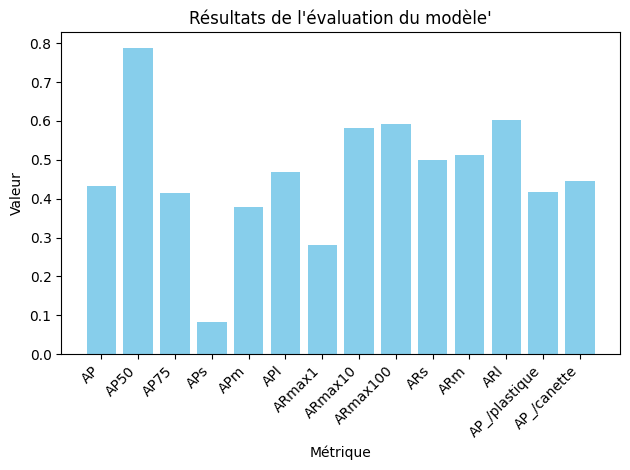

In [27]:
# https://cocodataset.org/#detection-eval
# val_loss, val_accuracy = model.evaluate(val_data)

evaluation = model.evaluate(val_data)

def plotEvaluation(eval, title="Résultats de l\'évaluation du modèle'"):
    import matplotlib.pyplot as plt
    plt.bar(eval.keys(), eval.values(), color='skyblue')
    plt.xlabel('Métrique')
    plt.ylabel('Valeur')
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plotEvaluation(evaluation)

## Export du modèle au format Tensorflow lite

In [28]:
config = QuantizationConfig.for_float16()
model.export(export_dir='bin/', 
             tflite_filename='greengardians-full.tflite', 
            #quantization_config=config
             )
# model.export(export_dir='bin/', 
#              quantization_config=config,
#              export_format=[ExportFormat.SAVED_MODEL, ExportFormat.LABEL])


2024-04-15 15:35:26.606720: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2024-04-15 15:35:44.313639: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-04-15 15:35:44.313693: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2024-04-15 15:35:44.316854: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpyykxomnv
2024-04-15 15:35:44.466132: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2024-04-15 15:35:44.466169: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpyykxomnv
2024-04-15 15:35:45.147020: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-04-15 15:35:48.133008: I tensorflow/cc/saved_

Estimated count of arithmetic ops: 13.698 G  ops, equivalently 6.849 G  MACs


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 0
2024-04-15 15:38:15.922735: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1963] Estimated count of arithmetic ops: 13.698 G  ops, equivalently 6.849 G  MACs



Estimated count of arithmetic ops: 13.698 G  ops, equivalently 6.849 G  MACs


## Evaluation du modèle entrainé

16/16 [==============================] - 7s 364ms/step



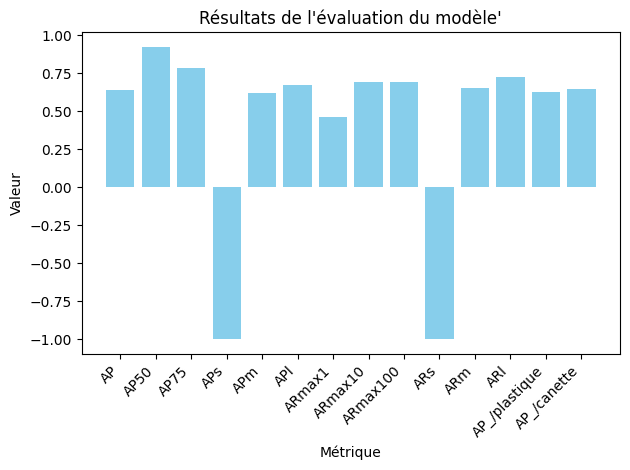

In [29]:
model_path = 'bin/greengardians.tflite'
evaluation_lite = model.evaluate_tflite(model_path, test_data)

plotEvaluation(evaluation_lite)

In [30]:
# NUMBER_OF_TPUS =  2

# !edgetpu_compiler 'bin/greengardians-full.tflite' --num_segments=$NUMBER_OF_TPUS

## Utilitaires

In [31]:
import cv2

from PIL import Image

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# classes = {0: "plastique", 1: "canette"}
print('classes', classes)

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)


  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])


  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results

def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  print('results', results)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

classes ['plastique', 'canette']


## Prediction

In [32]:
# Load the TFLite model
import os, random
from pathlib import Path
model_path = 'bin/greengardians.tflite'

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# # Run inference and draw detection result on the local copy of the original file
DETECTION_THRESHOLD = 0.5
          
PROJECT_FOLDER = Path(Path.cwd())
image_folder = str(PROJECT_FOLDER) + '/datasets/dataset.voc/test/'
# imageToPredict = 'datasets/dataset.voc/test/IMG_20231025_095509_jpg.rf.c83cb3628dda974ef28a37ce404b9ab7.jpg'
                                                          
l_detection_result_image = []
files = [image_folder +'/'+ f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# imageToPredict = 'datasets/dataset.voc/test/IMG_20231025_095509_jpg.rf.c83cb3628dda974ef28a37ce404b9ab7.jpg'
imageToPredict = random.choice(files)
print(imageToPredict)
detection_result_image = run_odt_and_draw_results(
        imageToPredict,
        interpreter,
        threshold=DETECTION_THRESHOLD
)
# for file in files:
#     detection_result_image = run_odt_and_draw_results(
#         file,
#         interpreter,
#         threshold=DETECTION_THRESHOLD
#     )
#     l_detection_result_image.append(detection_result_image)

/home/charles/web/alyra/villepropre/vp-server/train/datasets/dataset.voc/test//IMG_20231025_095258_jpg.rf.4fefc8f385ce0cc9867dc873007fdfc5.jpg


ValueError: Cannot set tensor: Got value of type UINT8 but expected type FLOAT32 for input 0, name: serving_default_images:0 

TypeError: Image data of dtype <U142 cannot be converted to float

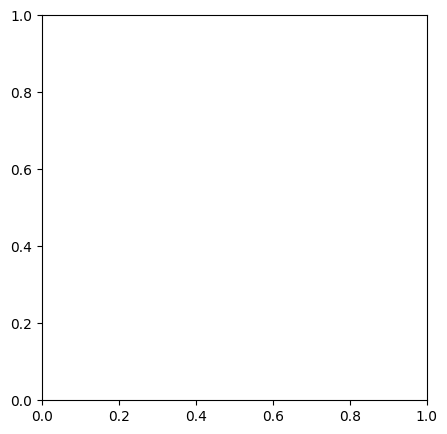

In [ ]:
Image.fromarray(detection_result_image)

# import matplotlib.pyplot as plt
# plt.figure(figsize=(5, 5))
# plt.imshow(imageToPredict)
# plt.show()
# plt.close()
# test_validation_folder = str(PROJECT_FOLDER) + '/datasets/dataset.voc/test_val/'

# # Show all the detection result
# for image in l_detection_result_image:
#     plt.figure(figsize=(5, 5))
#     plt.imshow(image)
#     plt.show()
#     # Save the image in the validation folder    
#     plt.close()